In [9]:
import cv2
import shutil
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [4]:
from pathlib import Path
# ===============================
# Original dataset paths
# ===============================
train_fire = Path("forest_fire/Training and Validation/fire")
train_nofire = Path("forest_fire/Training and Validation/nofire")
test_fire = Path("forest_fire/Testing/fire")
test_nofire = Path("forest_fire/Testing/nofire")

In [5]:
# ===============================
# YOLO dataset paths
# ===============================
BASE = Path("forest_fire_yolo")
img_train = BASE / "images/train"
img_val = BASE / "images/val"
lbl_train = BASE / "labels/train"
lbl_val = BASE / "labels/val"


In [6]:
for p in [img_train, img_val, lbl_train, lbl_val]:
    p.mkdir(parents=True, exist_ok=True)

In [7]:
# ===============================
# Convert to YOLO format
# ===============================
def convert(images, label, img_out, lbl_out):
    count = 0
    for img_path in images:
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        shutil.copy(img_path, img_out / img_path.name)

        txt_path = lbl_out / f"{img_path.stem}.txt"
        with open(txt_path, "w") as f:
            f.write(f"{label} 0.5 0.5 1.0 1.0")

        count += 1
    return count

In [10]:
# Convert datasets
train_fire_count = convert(train_fire.glob("*.jpg"), 0, img_train, lbl_train)
train_nofire_count = convert(train_nofire.glob("*.jpg"), 1, img_train, lbl_train)
val_fire_count = convert(test_fire.glob("*.jpg"), 0, img_val, lbl_val)
val_nofire_count = convert(test_nofire.glob("*.jpg"), 1, img_val, lbl_val)

In [11]:
# ===============================
# Print dataset statistics
# ===============================
print("✅ Dataset converted to YOLO format\n")

print("📊 Training Dataset:")
print(f"   Fire images     : {train_fire_count}")
print(f"   Non-Fire images : {train_nofire_count}")
print(f"   Total           : {train_fire_count + train_nofire_count}\n")

print("📊 Validation Dataset:")
print(f"   Fire images     : {val_fire_count}")
print(f"   Non-Fire images : {val_nofire_count}")
print(f"   Total           : {val_fire_count + val_nofire_count}")

✅ Dataset converted to YOLO format

📊 Training Dataset:
   Fire images     : 928
   Non-Fire images : 416
   Total           : 1344

📊 Validation Dataset:
   Fire images     : 22
   Non-Fire images : 46
   Total           : 68


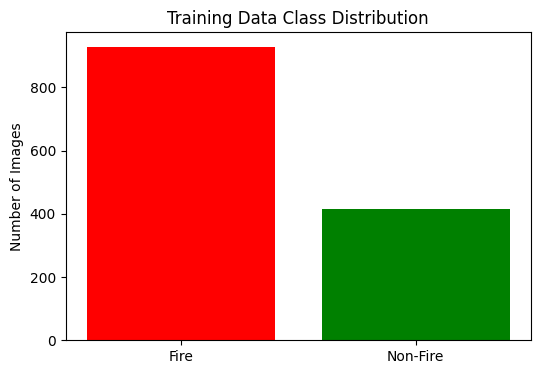

In [12]:
# ===============================
# Plot class distribution
# ===============================
train_labels = (
    [0] * train_fire_count +
    [1] * train_nofire_count
)
colors=['red', 'green']
plt.figure(figsize=(6,4))
plt.bar(["Fire", "Non-Fire"], Counter(train_labels).values(), color=colors)
plt.title("Training Data Class Distribution")
plt.ylabel("Number of Images")
plt.show()

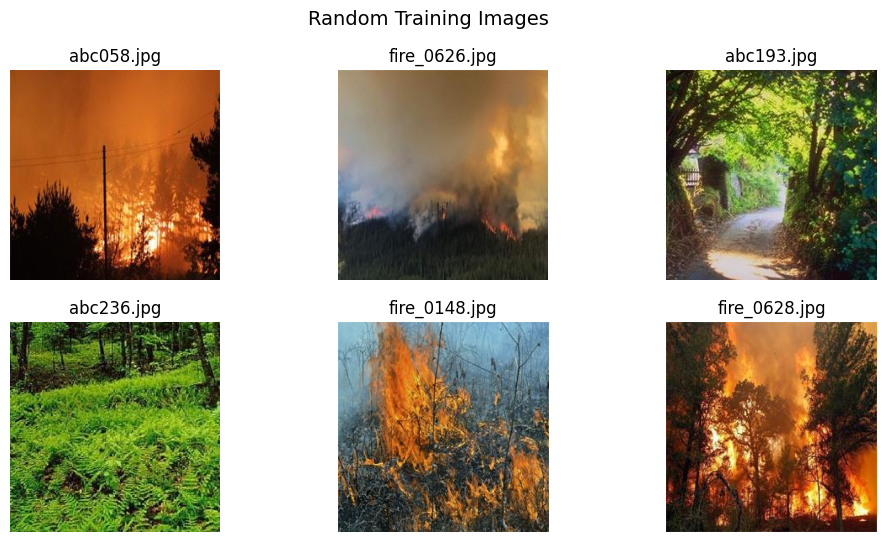

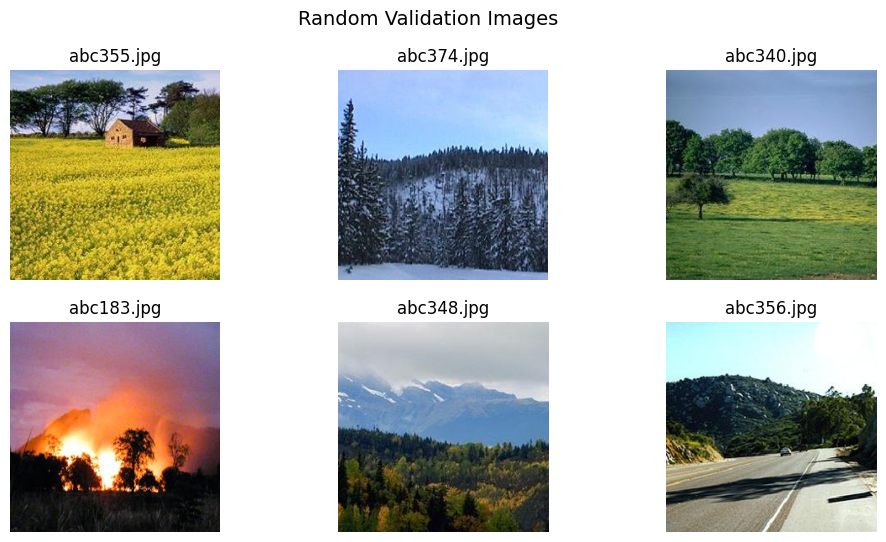

In [13]:
# ===============================
# Show random sample images
# ===============================
def show_random_images(folder, title, n=6):
    images = list(folder.glob("*.jpg"))
    samples = random.sample(images, min(n, len(images)))

    plt.figure(figsize=(12,6))
    for i, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

# Show samples
show_random_images(img_train, "Random Training Images")
show_random_images(img_val, "Random Validation Images")

In [14]:
import os
os.environ["MLFLOW_TRACKING_URI"] = "file:./mlruns"
os.environ["MLFLOW_ENABLE"] = "false"

In [16]:
import os
os.environ["MLFLOW_ENABLE"] = "false"

from ultralytics import YOLO

model = YOLO("yolov9t.pt")  # YOLOv9-Tiny

results = model.train(
    data=r"forest_fire\data.yaml",
    epochs=1,
    imgsz=640,
    batch=8,
    device="cpu",   # set to 0 if GPU
    project=r"runs",
    name="fire_detection"
)


Ultralytics 8.4.9  Python-3.12.6 torch-2.10.0+cpu CPU (11th Gen Intel Core i3-1115G4 @ 3.00GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=forest_fire\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9t.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=fire_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

In [24]:
import os
os.environ["MLFLOW_ENABLE"] = "false"
from ultralytics import YOLO

model = YOLO("yolov9.pt")
print("✅ Trained model loaded successfully")

FileNotFoundError: [Errno 2] No such file or directory: 'yolov9.pt'

In [18]:
metrics = model.val(
    data=r"forest_fire\data.yaml",
    imgsz=640,
    batch=8,
    device="cpu"
)

print("\n📊 Evaluation Metrics:")
print(f"mAP@0.5      : {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95 : {metrics.box.map:.4f}")
print(f"Precision    : {metrics.box.mp:.4f}")
print(f"Recall       : {metrics.box.mr:.4f}")

Ultralytics 8.4.9  Python-3.12.6 torch-2.10.0+cpu CPU (11th Gen Intel Core i3-1115G4 @ 3.00GHz)


YOLOv9t summary (fused): 197 layers, 1,971,174 parameters, 0 gradients, 7.6 GFLOPs
val: Fast image access  (ping: 0.30.3 ms, read: 16.93.0 MB/s, size: 11.6 KB)
val: Scanning C:\Users\nehaa\Downloads\forest_fire\forest_fire_yolo\labels\val.cache... 68 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 68/68  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.2s/it 19.9s2.6ss
                   all         68         68      0.868      0.799       0.89      0.861
                  Fire         22         22      0.809      0.773      0.833      0.806
              Non_Fire         46         46      0.927      0.826      0.947      0.915
Speed: 4.1ms preprocess, 260.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to C:\Users\nehaa\runs\detect\val

📊 Evaluation Metrics:
mAP@0.5      : 0.8901
mAP@0.5:0.95 : 0.8608
Precision    : 0.8680
Recall       : 0.7994


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

results_path = "results.csv"
df = pd.read_csv(results_path)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(df["train/box_loss"], label="Box Loss")
plt.plot(df["train/cls_loss"], label="Class Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(df["metrics/precision(B)"], label="Precision")
plt.plot(df["metrics/recall(B)"], label="Recall")
plt.plot(df["metrics/mAP50(B)"], label="mAP@0.5")
plt.title("Evaluation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results.csv'

In [21]:
print("========== YOLOv9 Fire Detection Summary ==========")
print(f"Model        : YOLOv9-T")
print(f"Epochs       : 1")
print(f"Image Size   : 640x640")
print(f"Classes      : Fire, Non-Fire")
print(f"mAP@0.5      : {metrics.box.map50:.4f}")
print(f"Precision    : {metrics.box.mp:.4f}")
print(f"Recall       : {metrics.box.mr:.4f}")
print("=================================================")

========== YOLOv9 Fire Detection Summary ==========
Model        : YOLOv9-T
Epochs       : 1
Image Size   : 640x640
Classes      : Fire, Non-Fire
mAP@0.5      : 0.8901
Precision    : 0.8680
Recall       : 0.7994
